# 폐렴을 진단해보자

## 1) 라이브러리 불러오기

In [1]:
import os,re
import random,math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2) 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)#tf.io.gfile.glob = 지정된 패턴과 일치하는 파일 목록을 반환합니다.
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train : 5216개
- test : 624개
- val : 16개  
개수 비 - 89:10.7:0.3
val 개수가 너무 적기 때문에 train에서 val 데이터를 가져온다

train에서 val에 쓰일 데이터 가져오기
train : val = 80 : 20

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))#extend 함수 : 리스트에 많은 요소를 넣을 때 쓰는 것

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)#리스트 안에 있는 요소들을 섞는다
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- filenames에 train데이터를 넣는다
- train데이터가 넣어져 있는 filenames에 extend 함수를 써 Val데이터를 추가한다
- train_size = filenames(5216+16) * 0.8 을 계산한 뒤 floor 함수로 인한 소수점은 버림
- shuffle로 인해 요소들을 섞고 random.seed로 인해 섞어진 리스트를 그대로 가져간다.
- train_filenames는 0\~4184, val_filenames는 4185\~5231

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


일반인 폐 사진은 1072개
폐렴 사진은 3113개

결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- tf.data 인스턴스 만들기

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 라벨데이터를 만들어주는 함수

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- 이미시 사이즈 통일과, GPU메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 축소
- decode_ing 함수와 process_path 함수 생성
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경 
- get_label을 이용해서 라벨 값을 가져온다

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- train 데이터 셋과 validation 데이터 셋을 만든다 
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리 가능

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- test데이터도 train과 val데이터처럼 만들기

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜줌
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## 3) 데이터 시각화

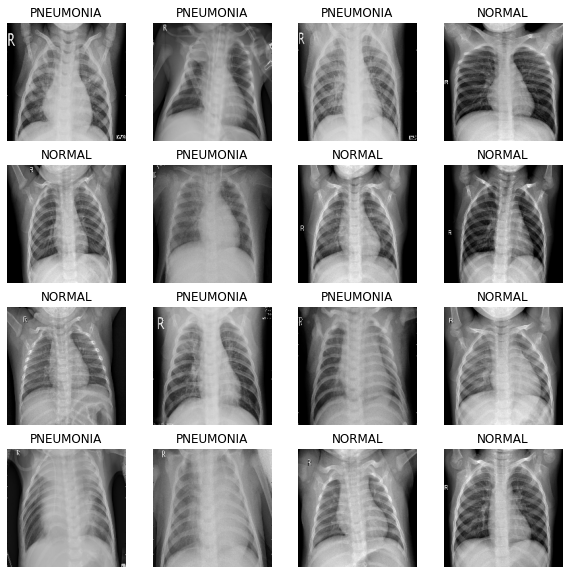

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4) CNN모델링

Convolution block을 만든다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결. 그리고 Max Pooling을 한다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5) 데이터 imbalance 처리

imbalance한 데이터의 경우 학습 효과가 좋지않은데 이러한 문제를 해결하는 방법은 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다

weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅  
weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정된다

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6)-1 모델훈련 (batch size = 16, epoch = 25)

- build_model()을 model에 선언  
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용  
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 89s 191ms/step - loss: 0.3705 - accuracy: 0.8300 - precision: 0.9590 - recall: 0.8059 - val_loss: 0.7312 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2136 - accuracy: 0.9210 - precision: 0.9806 - recall: 0.9118 - val_loss: 1.3953 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1968 - accuracy: 0.9270 - precision: 0.9736 - recall: 0.9270 - val_loss: 0.9403 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1887 - accuracy: 0.9260 - precision: 0.9752 - recall: 0.9240 - val_loss: 0.1151 - val_accuracy: 0.9587 - val_precision: 0.9945 - val_recall: 0.9490
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1652 - accura

## 7)-1 결과확인(batch size = 16, epoch = 25)

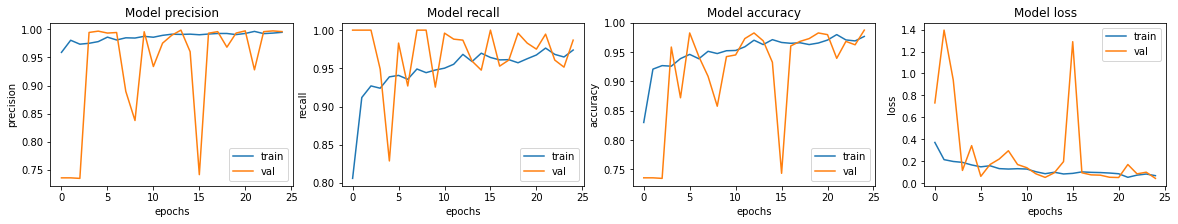

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.9921 - accuracy: 0.8189 - precision: 0.7821 - recall: 0.9846
Loss: 0.9920989871025085,
Accuracy: 0.8189102411270142,
Precision: 0.7820773720741272,
Recall: 0.9846153855323792


## 6)-2 모델훈련 (batch size = 20, epoch = 30)

- build_model()을 model에 선언  
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용  
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [24]:
BATCH_SIZE = 20
EPOCHS = 30

In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 50s 198ms/step - loss: 0.4021 - accuracy: 0.7961 - precision: 0.9470 - recall: 0.7667 - val_loss: 0.6410 - val_accuracy: 0.7416 - val_precision: 0.7416 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 41s 194ms/step - loss: 0.2502 - accuracy: 0.9031 - precision: 0.9704 - recall: 0.8986 - val_loss: 1.3268 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 40s 193ms/step - loss: 0.2269 - accuracy: 0.9154 - precision: 0.9710 - recall: 0.9138 - val_loss: 1.5320 - val_accuracy: 0.7296 - val_precision: 0.7296 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 41s 199ms/step - loss: 0.2085 - accuracy: 0.9211 - precision: 0.9746 - recall: 0.9169 - val_loss: 0.5514 - val_accuracy: 0.7584 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 5/30
209/209 [==============================] - 42s 201ms/step - loss: 0.1882 - accura

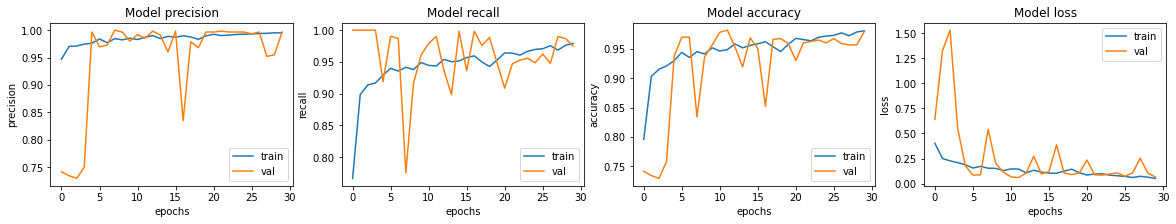

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 0.9533 - accuracy: 0.8077 - precision: 0.7711 - recall: 0.9846
Loss: 0.9533042907714844,
Accuracy: 0.807692289352417,
Precision: 0.7710843086242676,
Recall: 0.9846153855323792


## 6)-3 모델훈련 (batch size = 30, epoch = 20)

In [29]:
BATCH_SIZE = 30
EPOCHS = 20

In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
139/139 [==============================] - 40s 222ms/step - loss: 0.4600 - accuracy: 0.7779 - precision: 0.9475 - recall: 0.7423 - val_loss: 0.5743 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall: 1.0000
Epoch 2/20
139/139 [==============================] - 30s 215ms/step - loss: 0.2702 - accuracy: 0.8916 - precision: 0.9745 - recall: 0.8773 - val_loss: 0.7335 - val_accuracy: 0.7353 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 3/20
139/139 [==============================] - 30s 215ms/step - loss: 0.2482 - accuracy: 0.9141 - precision: 0.9717 - recall: 0.9113 - val_loss: 0.9766 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall: 1.0000ss: 0
Epoch 4/20
139/139 [==============================] - 30s 216ms/step - loss: 0.2074 - accuracy: 0.9177 - precision: 0.9767 - recall: 0.9112 - val_loss: 1.2261 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall: 1.0000
Epoch 5/20
139/139 [==============================] - 30s 220ms/step - loss: 0.2151 - a

## 7)-3 결과확인(batch size = 30, epoch = 20)

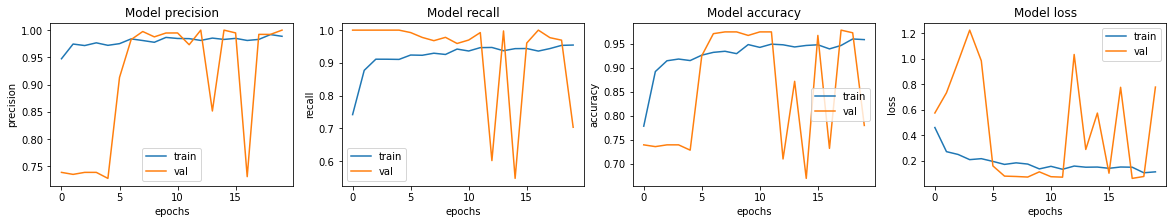

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.6605 - accuracy: 0.8109 - precision: 0.9048 - recall: 0.7795
Loss: 0.660469651222229,
Accuracy: 0.8108974099159241,
Precision: 0.9047619104385376,
Recall: 0.7794871926307678


## 6)-4 모델훈련 (batch size = 40, epoch = 30)

In [34]:
BATCH_SIZE = 40
EPOCHS = 30

In [35]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
104/104 [==============================] - 34s 237ms/step - loss: 0.5058 - accuracy: 0.7278 - precision: 0.9402 - recall: 0.6803 - val_loss: 0.6047 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/30
104/104 [==============================] - 25s 240ms/step - loss: 0.2867 - accuracy: 0.8648 - precision: 0.9725 - recall: 0.8446 - val_loss: 0.6300 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/30
104/104 [==============================] - 25s 241ms/step - loss: 0.2357 - accuracy: 0.9123 - precision: 0.9725 - recall: 0.9050 - val_loss: 0.6529 - val_accuracy: 0.7596 - val_precision: 0.7596 - val_recall: 1.0000
Epoch 4/30
104/104 [==============================] - 25s 240ms/step - loss: 0.2373 - accuracy: 0.9111 - precision: 0.9729 - recall: 0.9048 - val_loss: 0.8826 - val_accuracy: 0.7548 - val_precision: 0.7548 - val_recall: 1.0000
Epoch 5/30
104/104 [==============================] - 26s 251ms/step - loss: 0.2343 - accura

## 7)-4 결과확인(batch size = 40, epoch = 30)

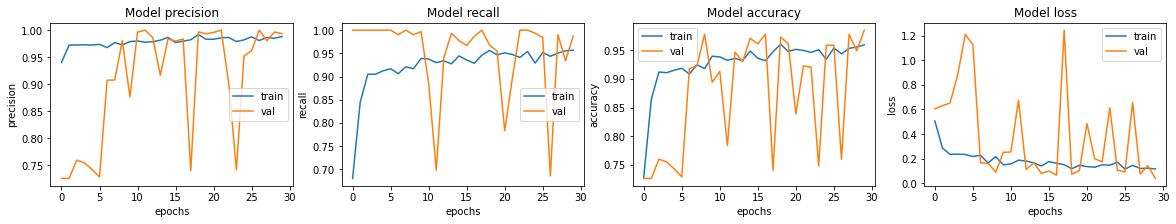

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.0009 - accuracy: 0.7484 - precision: 0.7130 - recall: 1.0000
Loss: 1.0008556842803955,
Accuracy: 0.7483974099159241,
Precision: 0.7129799127578735,
Recall: 1.0


## 6)-4 모델훈련 (batch size = 12, epoch = 30)

In [39]:
BATCH_SIZE = 12
EPOCHS = 30

In [40]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
348/348 [==============================] - 74s 185ms/step - loss: 0.3779 - accuracy: 0.8217 - precision: 0.9505 - recall: 0.8020 - val_loss: 0.7130 - val_accuracy: 0.7306 - val_precision: 0.7306 - val_recall: 1.0000
Epoch 2/30
348/348 [==============================] - 64s 184ms/step - loss: 0.2091 - accuracy: 0.9172 - precision: 0.9742 - recall: 0.9126 - val_loss: 0.9548 - val_accuracy: 0.7342 - val_precision: 0.7342 - val_recall: 1.0000
Epoch 3/30
348/348 [==============================] - 64s 185ms/step - loss: 0.1913 - accuracy: 0.9289 - precision: 0.9771 - recall: 0.9263 - val_loss: 0.1073 - val_accuracy: 0.9598 - val_precision: 0.9538 - val_recall: 0.9931
Epoch 4/30
348/348 [==============================] - 64s 185ms/step - loss: 0.1694 - accuracy: 0.9343 - precision: 0.9792 - recall: 0.9314 - val_loss: 0.1083 - val_accuracy: 0.9612 - val_precision: 0.9540 - val_recall: 0.9951
Epoch 5/30
348/348 [==============================] - 64s 185ms/step - loss: 0.1452 - accura

## 7)-4 결과확인(batch size = 12, epoch = 30)

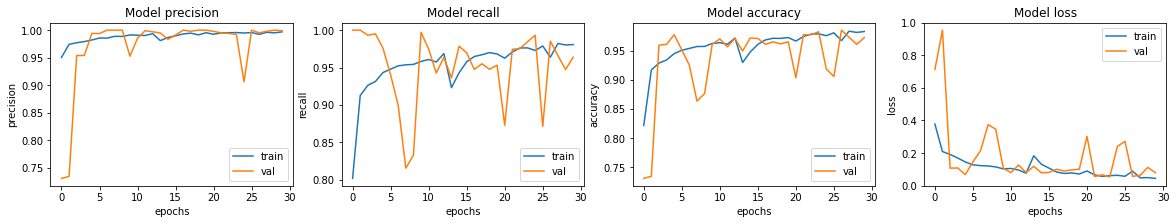

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.6401 - accuracy: 0.8013 - precision: 0.7628 - recall: 0.9897
Loss: 1.6400606632232666,
Accuracy: 0.8012820482254028,
Precision: 0.7628458738327026,
Recall: 0.9897435903549194


## 6)-5 모델훈련 (batch size = 10, epoch = 25)

In [49]:
BATCH_SIZE = 10
EPOCHS = 25

In [50]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [51]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
418/418 [==============================] - 84s 179ms/step - loss: 0.3026 - accuracy: 0.8644 - precision: 0.9633 - recall: 0.8501 - val_loss: 0.8515 - val_accuracy: 0.7428 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 2/25
418/418 [==============================] - 74s 178ms/step - loss: 0.1977 - accuracy: 0.9242 - precision: 0.9768 - recall: 0.9202 - val_loss: 0.1071 - val_accuracy: 0.9561 - val_precision: 0.9498 - val_recall: 0.9926
Epoch 3/25
418/418 [==============================] - 74s 176ms/step - loss: 0.1725 - accuracy: 0.9368 - precision: 0.9803 - recall: 0.9335 - val_loss: 0.2521 - val_accuracy: 0.9225 - val_precision: 1.0000 - val_recall: 0.8938
Epoch 4/25
418/418 [==============================] - 74s 178ms/step - loss: 0.1400 - accuracy: 0.9451 - precision: 0.9841 - recall: 0.9416 - val_loss: 0.0670 - val_accuracy: 0.9784 - val_precision: 0.9943 - val_recall: 0.9766
Epoch 5/25
418/418 [==============================] - 75s 179ms/step - loss: 0.1451 - accura

## 7)-5 결과확인(batch size = 10, epoch = 25)

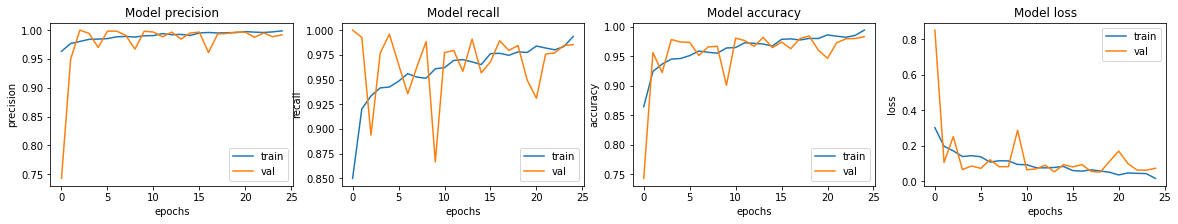

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [53]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 1.7191 - accuracy: 0.7788 - precision: 0.7395 - recall: 0.9974
Loss: 1.7190653085708618,
Accuracy: 0.7788461446762085,
Precision: 0.7395437359809875,
Recall: 0.9974358677864075


## 6)-6 모델훈련 (batch size = 30, epoch = 20)(optimizer = 'rmsprop')

In [54]:
BATCH_SIZE = 30
EPOCHS = 20

In [55]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [56]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
139/139 [==============================] - 40s 222ms/step - loss: 0.4833 - accuracy: 0.7630 - precision: 0.9340 - recall: 0.7313 - val_loss: 0.5891 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 2/20
139/139 [==============================] - 29s 213ms/step - loss: 0.3175 - accuracy: 0.8620 - precision: 0.9614 - recall: 0.8501 - val_loss: 0.7355 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 3/20
139/139 [==============================] - 30s 215ms/step - loss: 0.2609 - accuracy: 0.8889 - precision: 0.9631 - recall: 0.8866 - val_loss: 0.9025 - val_accuracy: 0.7518 - val_precision: 0.7518 - val_recall: 1.0000
Epoch 4/20
139/139 [==============================] - 30s 220ms/step - loss: 0.2683 - accuracy: 0.9069 - precision: 0.9616 - recall: 0.9089 - val_loss: 1.2767 - val_accuracy: 0.7629 - val_precision: 0.7629 - val_recall: 1.0000
Epoch 5/20
139/139 [==============================] - 31s 221ms/step - loss: 0.2433 - accura

## 7)-6 결과확인(batch size = 30, epoch = 20)(optimizer = 'rmsprop')

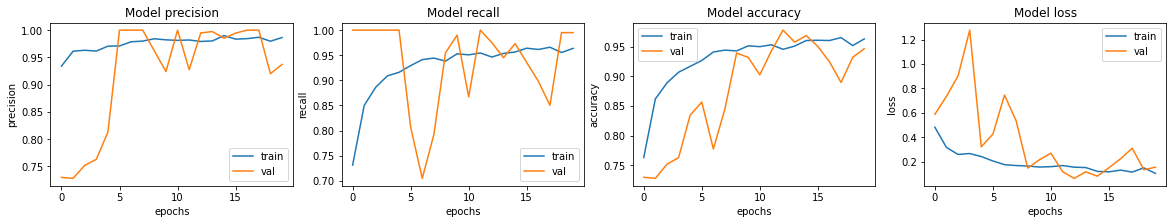

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [58]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 1.3621 - accuracy: 0.6875 - precision: 0.6667 - recall: 1.0000
Loss: 1.3620697259902954,
Accuracy: 0.6875,
Precision: 0.6666666865348816,
Recall: 1.0


## 6)-7 모델훈련 (batch size = 16, epoch = 25)(optimizer = 'rmsprop')

In [59]:
BATCH_SIZE = 16
EPOCHS = 25

In [60]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [61]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 189ms/step - loss: 0.3998 - accuracy: 0.7981 - precision: 0.9422 - recall: 0.7763 - val_loss: 0.6596 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2351 - accuracy: 0.9183 - precision: 0.9694 - recall: 0.9191 - val_loss: 0.9766 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1928 - accuracy: 0.9370 - precision: 0.9747 - recall: 0.9399 - val_loss: 0.5074 - val_accuracy: 0.8038 - val_precision: 1.0000 - val_recall: 0.7333
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1842 - accuracy: 0.9346 - precision: 0.9707 - recall: 0.9404 - val_loss: 1.0190 - val_accuracy: 0.7673 - val_precision: 1.0000 - val_recall: 0.6841
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1741 - accura

## 7)-7 결과확인(batch size = 16, epoch = 25)(optimizer = 'rmsprop')

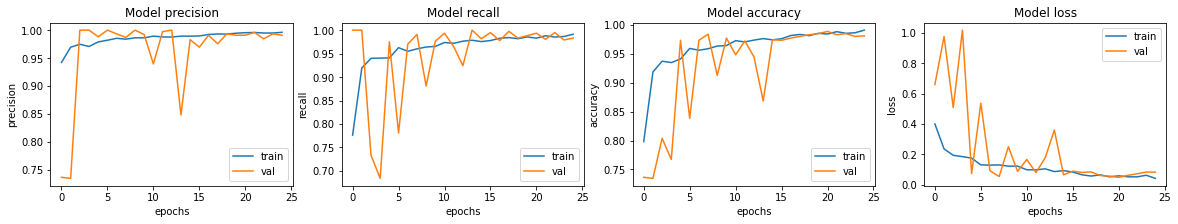

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.6524 - accuracy: 0.7660 - precision: 0.7276 - recall: 1.0000
Loss: 1.6524251699447632,
Accuracy: 0.7660256624221802,
Precision: 0.7276119589805603,
Recall: 1.0


## 회고

- batch size와 epoch를 처음에 바꾼 후 학습을 하고 결과를 보았을 때 별로 달라진 결과를 보지는 못했다.
- optimizer를 rmsprop로 변경하고 난 뒤 학습을 진행하였어도 accuracy는 증가가 되지 않았다.
- 새로 파일을 만들어 학습을 진행하려고 했지만 계속 커널이 죽어버려 학습하기 힘들었다.
- 최고 높은 accuracy는 가장 처음에 한 6-1 81%로 비록 85%는 넘지 못해 이 프로젝트는 아쉬운 결과를 가졌다.